The -3dB cutoff frequency (f_c) is: 4.69 Hz


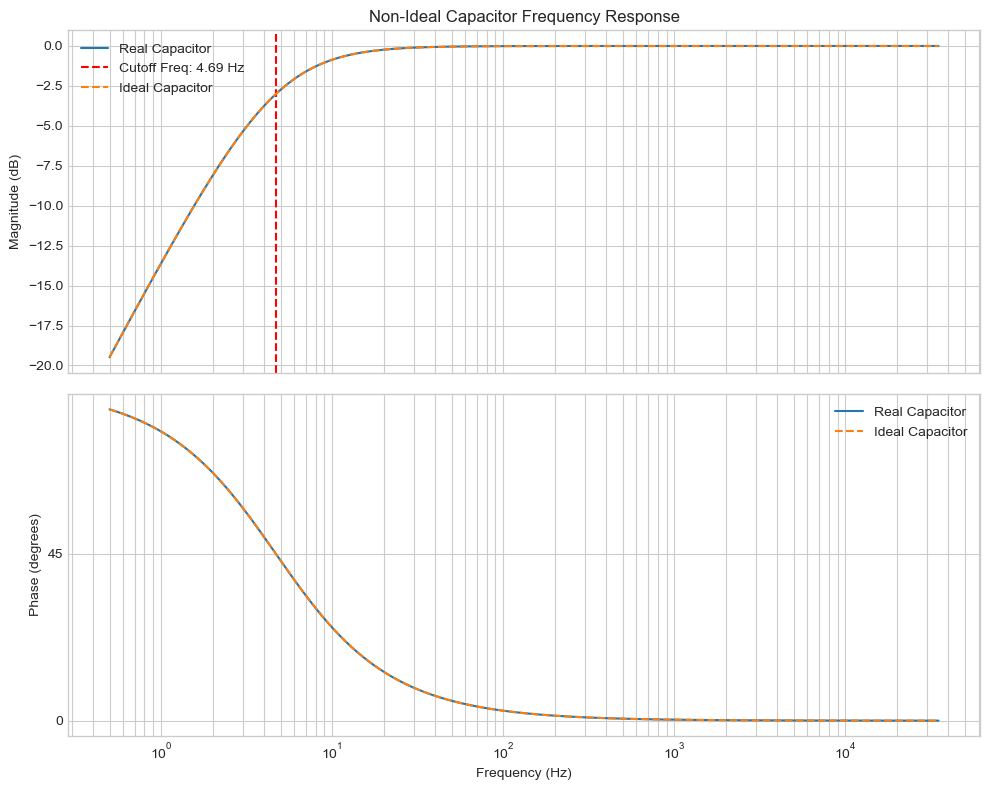

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def calculate_non_ideal_frequency_response(R, C, tanδ, tanδf, frequencies):
    """
    Calculates the magnitude frequency response for a non-ideal capacitor
    in a RC high-pass filter

    Args:
        R (float): Resistance in Ohms (input impedance of the next stage)
        C (float): Capacitance in Farads
        frequencies (array-like): Frequencies in Hz to evaluate

    Returns:
        tuple: (frequencies, magnitude_response_dB)
    """
    # Angular frequency
    omega = 2 * np.pi * frequencies
    
    logx = np.log10(tanδf)
    logy = np.log10(tanδ)
    lin_interp = interp1d(logx, logy, kind = "linear", fill_value = "extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    interp_tanδ = log_interp(frequencies)
    
    ESR = interp_tanδ * (2 * np.pi * frequencies * C) ** -1      # equivalent series resistance (Ohms)
    ESL = 10e-9    # equivalent series inductance (Henries)
    EPR = 1e9       # equivalent parallel resistance (leakage) (Ohms)
    
    # Calculate impedance for the non-ideal capacitor model
    # Parallel combination of EPR and C
    Z_parallel = (EPR * (1/(1j * omega * C))) / (EPR + (1/(1j * omega * C)))
    
    # Total impedance
    Z_total = ESR + 1j * omega * ESL + Z_parallel
    
    # Transfer function H(j*omega) for a high-pass RC filter:
    transfer_function = R / (R  + Z_total)

    # Calculate magnitude (in dB) and phase (in degrees)
    # Magnitude of the transfer function
    magnitude = np.abs(transfer_function)
    
    # Magnitude in Decibels (dB)
    magnitude_dB = 20 * np.log10(magnitude)
    phase_deg = np.angle(transfer_function, deg = True)
    
    return frequencies, magnitude_dB, phase_deg

def calculate_ideal_frequency_response(R, C, frequencies):
    """
    Calculates the magnitude frequency response for an ideal capacitor
    in a RC high-pass filter (ESR=0, ESL=0, EPR=infinity)

    Args:
        R (float): Resistance in Ohms (input impedance of the next stage)
        C (float): Capacitance in Farads
        frequencies (array-like): Frequencies in Hz to evaluate

    Returns:
        tuple: (frequencies, magnitude_response_dB, phase_deg)
    """
    # Angular frequency
    omega = 2 * np.pi * frequencies

    Z_ideal = 1/(1j * omega * C)
    
    # Transfer function H(j*omega) for a high-pass RC filter:
    transfer_function = R / (R  + Z_ideal)

    # Calculate magnitude (in dB) and phase (in degrees)
    # Magnitude of the transfer function
    magnitude = np.abs(transfer_function)
    
    # Magnitude in Decibels (dB)
    magnitude_dB = 20 * np.log10(magnitude)
    phase_deg = np.angle(transfer_function, deg = True)
    
    return frequencies, magnitude_dB, phase_deg

def calculate_cutoff_frequency(R, C):
    """Calculates the -3dB cutoff frequency (f_c) in Hz."""
    f_c = 1 / (2 * np.pi * R * C)
    return f_c

# --- Parameters ---
# Output impedance
resistance_ohms = 1 / ((1 / 600) + (1 / 10000))  # R in Ohms

# Define non-ideal capacitor parameters
capacitance_farads = 60e-6 # C in Farads (1uF)
tanδ = [15e-4, 160e-4]
tanδf = [1e3, 1e4]

# # Define non-ideal capacitor parameters
# capacitance_farads = 40e-6 # C in Farads (1uF)
# tanδ = [15e-4, 160e-4]
# tanδf = [1e3, 1e4]

# Generate a range of frequencies (log scale is better for audio)
f_start = 0.5 # Hz
f_end = 35000 # Hz
num_points = 1000
frequencies = np.logspace(np.log10(f_start), np.log10(f_end), num_points)

# --- Calculation ---
freqs1, mag_db1, phs_deg1 = calculate_non_ideal_frequency_response(resistance_ohms, capacitance_farads, tanδ, tanδf, frequencies)
freqs2, mag_db2, phs_deg2 = calculate_ideal_frequency_response(resistance_ohms, capacitance_farads, frequencies)
cutoff_freq = calculate_cutoff_frequency(resistance_ohms, capacitance_farads)

print(f"The -3dB cutoff frequency (f_c) is: {cutoff_freq:.2f} Hz")

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize = (10, 8), sharex = True)

# Magnitude Plot
ax_mag.semilogx(freqs1, mag_db1, label = 'Real Capacitor')
ax_mag.axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff Freq: {cutoff_freq:.2f} Hz')
ax_mag.set_title('Non-Ideal Capacitor Frequency Response')
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.grid(True, which = "both", ls = "-")

# Phase Plot
ax_phase.semilogx(freqs1, phs_deg1, label = 'Real Capacitor')
ax_phase.set_xlabel('Frequency (Hz)')
ax_phase.set_ylabel('Phase (degrees)')
ax_phase.set_yticks([-90, -45, 0, 45, 90])
ax_phase.grid(True, which = "both", ls = "-")
plt.tight_layout()

# Add ideal capacitor plot to the magnitude axis
ax_mag.semilogx(freqs2, mag_db2, '--', label = 'Ideal Capacitor')
ax_mag.legend()

# Add ideal capacitor plot to the phase axis
ax_phase.semilogx(freqs2, phs_deg2, '--', label = 'Ideal Capacitor')
ax_phase.legend()
plt.show()